# Script for Wind Regression
We cross validate our threshold value and perform regression on the best one!

In [2]:
### Import basic libraries
import os
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
#%matplotlib inline
import time
import glob
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Figure factory 
import plotly 
import plotly.figure_factory as ff
import geopandas

import requests
import plotly.express as px
#from urllib3.request import urlopen
import json
import requests
from urllib.request import urlopen

# Get county info for plotting 
response = urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')
counties = json.load(response)


df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

In [3]:
# state = "Nebraska"
# state2 = "Iowa"
# state3 = "Kansas"
# states = [state.upper(), state2.upper(), state3.upper()]
county_yield = pd.read_csv("../../data/data_yield/USA_county_yield_gsw.csv")
#state_yield = county_yield.loc[county_yield['State'] == state.upper()]
filenames = glob.glob("/Users/julianschmitt/Downloads/Direcho/processed/*/*") # get all processed files

state_lc = os.listdir("/Users/julianschmitt/Downloads/Direcho/processed")
states = [state.upper() for state in state_lc]
counties = np.unique([str("_".join(file.split("_")[1:3])) for file in filenames])
print(f"This script will regress {len(states)} states and {len(counties)} counties.")

This script will regress 12 states and 907 counties.


In [27]:
state_lc

['Missouri',
 'Illinois',
 '.DS_Store',
 'South Dakota',
 'Ohio',
 'Indiana',
 'Iowa',
 'Wisconsin',
 'Minnesota',
 'North Dakota',
 'Kansas',
 'Nebraska']

In [4]:
# We define the following metrics for growing and killing winds 
def kill_winds(windspeed, threshold):
    if windspeed <= threshold:
        return 0
    else:
        return windspeed - threshold
kill_vectorized = np.vectorize(kill_winds)

def grow_winds(windspeed, threshold):
    if windspeed <= 2:
        return windspeed
    elif (windspeed>2) & (windspeed<threshold-2):
        return 2
    elif (windspeed <= threshold) & (windspeed > threshold-2):
        return threshold - windspeed
    else:
        return 0
grow_vectorized = np.vectorize(grow_winds)

#GDD and KDD functions
def KDD_fn(x, threshold):
    if x < threshold:
        return 0
    if x >= threshold:
        return x - threshold
def GDD_fn(x, t1, t2):
    if x <t1:
        return 0
    if t1<=x<t2:
        return x-t1
    if x>=t2:
        return 24

In [8]:
def compute_KD(filenames, height, thresholds):
    """ Takes a list of wind data files and returns 
         - location based metrics: year, state, county
         - log-yield
         - sum of windspeed, windspeed^2, windspeed^3
         - GDD, KDD, KW, and GW derived from the data
        Returns in a big dataframe
    """
    data_plt = []
    #hourly_winds = [] # array of arrays of windspeeds 
    for i in range(len(filenames)):
        wind_i = pd.read_csv(filenames[i], low_memory = False)
        county_name = filenames[i].split("_")[-2].upper() # extract county name
        state_name = filenames[i].split("_")[-3].upper() # extract state name
        county_data = county_yield.loc[(county_yield['County'] == county_name) \
                                       & (county_yield['State']==state_name)] # kansas yeild data
        c_year = county_data["Year"].unique() 
        w_year = wind_i["Year"].unique()
        years = np.intersect1d(c_year, w_year) # finds all common values -essentially just the wind years 
        # filter years 
        county_gs = county_data[county_data["Year"].isin(years)] 
        wind_gs = wind_i[wind_i["Year"].isin(years)]
        wind_gs = wind_gs[(wind_gs["Month"] >= 4) & (wind_gs["Month"] <= 10)] # growing season
        for y in years:
            wind_raw = wind_gs.loc[wind_gs["Year"] == y][height].values # grab wind data
            county_gs_y = county_gs.loc[county_gs["Year"] == y] # get yield data
            #w_gs_y = wind_gs_y[height] # compute for specific height
            average_winds = np.mean(wind_raw)
            average_winds2 = np.mean(wind_raw**2) # sum of squares
            average_winds3 = np.mean(wind_raw**3) # sum of cubes
            # Compute the killing and growing wind values over wind_raw
            kill_w, grow_w = [], []
            for ind, thresh_cv in enumerate(thresholds):
                kill_w = kill_w.append(np.sum([kill_winds(t,thresh_cv) for t in wind_raw]))
                grow_w = grow_w.append(np.sum([grow_winds(t,thresh_cv) for t in wind_raw]))
                # compute KDD and GDD
                temperature_raw = wind_gs.loc[wind_gs["Year"] == y]["temp_10"].values
                KDD = np.sum([KDD_fn(t, 30) for t in temperature_raw])
                GDD = np.sum([GDD_fn(t, 8, 30) for t in temperature_raw])
                # year, state county, ln_yield, GDD, KDD  - merge with average wind speeds
                data = np.append(county_gs_y.iloc[:,[1,3,5,12,16,20]].values, [GDD, KDD, average_winds, average_winds2, average_winds3], kill_w, grow_w).tolist()
                data_plt.append(data) # append to data
    data_plt = np.array(data_plt)
    kwind_cols, gwind_cols = [f'KW_{thresh}' for thresh in thresholds], [f'GW_{thresh}' for thresh in thresholds]
    cols = np.concatenate([['Year', 'State', 'County', 'lnyield', 'PPT','PPT2', 'GDD', 'KDD', 'MeanWindspeed', \
            "Windspeed2", "Windspeed3","KW","GW"],kwind_cols,gwind_cols])
    df_plt = pd.DataFrame(data_plt, columns = cols)
    # convert to correct datatype
    df_plt[['lnyield','PPT','PPT2','GDD','KDD','KW','GW','MeanWindspeed','Windspeed2','Windspeed3']]= \
                                df_plt.drop(['Year','State','County'], axis=1).astype('float64')
    df_plt['Year'] = df_plt['Year'].astype('int32')
    
    df_mean = df_plt.groupby(by=["Year","State","County"], axis=0, as_index=False).mean()
    df_mean['ST_CO'] = df_mean['State']+'_'+df_mean['County'] # get unique county identifiers
    df_mean['PPT_SQUARE'] = df_mean['PPT']**2 # add precipitation squared variable for regression
    return df_mean

In [9]:
def compute_metrics(filenames, height, thresholds):
    all_metrics = []
    #hourly_winds = [] # array of arrays of windspeeds 
    for i in range(len(filenames)):
        wind_i = pd.read_csv(filenames[i], low_memory = False)
        county_name = filenames[i].split("_")[-2].upper() # extract county name
        state_name = filenames[i].split("_")[-3].upper() # extract state name
        county_data = county_yield.loc[(county_yield['County'] == county_name) \
                                       & (county_yield['State']==state_name)] # kansas yeild data
        c_year = county_data["Year"].unique() 
        w_year = wind_i["Year"].unique()
        years = np.intersect1d(c_year, w_year) # finds all common values -essentially just the wind years 
        # filter years 
        county_gs = county_data[county_data["Year"].isin(years)] 
        wind_gs = wind_i[wind_i["Year"].isin(years)]
        wind_gs = wind_gs[(wind_gs["Month"] >= 4) & (wind_gs["Month"] <= 10)] # growing season
        for y in years:
            wind_raw = wind_gs.loc[wind_gs["Year"] == y][height].values # grab wind data
            county_raw = county_gs.loc[county_gs["Year"] == y] # get yield data
            average_winds = np.mean(wind_raw)
            average_winds2 = np.mean(wind_raw**2) # sum of squares
            average_winds3 = np.mean(wind_raw**3) # sum of cubes
            # Compute the killing and growing wind values over wind_raw
            kill_w, grow_w = [], []
            for ind, thresh_cv in enumerate(thresholds):
                kill_w.append(np.sum([kill_winds(t,thresh_cv) for t in wind_raw]))
                grow_w.append(np.sum([grow_winds(t,thresh_cv) for t in wind_raw]))
            # compute KDD and GDD
            temperature_raw = wind_gs.loc[wind_gs["Year"] == y]["temp_10"].values
            KDD = np.sum([KDD_fn(t, 30) for t in temperature_raw])
            GDD = np.sum([GDD_fn(t, 8, 30) for t in temperature_raw])
            # year, state county, ln_yield, GDD, KDD  - merge with computed temp and windspeed metrics
            all_raw_data = np.concatenate([county_raw.iloc[:,[1,3,5,12,16,20]].values[0],[GDD, KDD, \
                                            average_winds, average_winds2, average_winds3],kill_w, grow_w],axis=0)
            all_metrics.append(all_raw_data) # append to data
    kwind_cols, gwind_cols = [f'KW_{thresh}' for thresh in thresholds], [f'GW_{thresh}' for thresh in thresholds]
    cols = np.concatenate([['Year', 'State', 'County', 'lnyield', 'PPT','PPT2', 'GDD', 'KDD', 'MeanWindspeed', \
            "Windspeed2", "Windspeed3"],kwind_cols,gwind_cols])
    df_metrics = pd.DataFrame(np.array(all_metrics), columns = cols)
    # convert to correct datatype
    cols2 = np.concatenate([['lnyield', 'PPT','PPT2', 'GDD', 'KDD', 'MeanWindspeed', \
            "Windspeed2", "Windspeed3"],kwind_cols,gwind_cols])
    # print(len(cols2), df_metrics.drop(['Year','State','County'], axis=1).astype('float64').shape)
    # print(df_metrics.head())
    df_metrics[cols2] = df_metrics.drop(['Year','State','County'], axis=1).astype('float64')
    df_metrics['Year'] = df_metrics['Year'].astype('int32')

    df_mean = df_metrics.groupby(by=["Year","State","County"], axis=0, as_index=False).mean()
    df_mean['ST_CO'] = df_mean['State']+'_'+df_mean['County'] # get unique county identifiers
    df_mean['PPT_SQUARE'] = df_mean['PPT']**2 # add precipitation squared variable for regression
    return df_mean


In [10]:
height, thresholds = 'wind_10ms', np.arange(2,26)
df_mean = compute_metrics(filenames, height, thresholds)

/Users/julianschmitt/opt/anaconda3/envs/covid/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/julianschmitt/opt/anaconda3/envs/covid/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
def extract_params(model, threshold):
    dct = {"threshold":threshold, "Coef KW":model.params[f"KW_{threshold}"], "KW Pvalue":model.pvalues[f"KW_{threshold}"], \
           "KW SE":model.bse[f'KW_{threshold}'], "rsquared":model.rsquared, 'adj_rsquared':model.rsquared_adj,
          "Coef GW":model.params[f"GW_{threshold}"], "GW Pvalue":model.pvalues[f"GW_{threshold}"], \
           "GW SE":model.bse[f'GW_{threshold}'], "Coef PPT":model.params["PPT"], "PPT Pvalue":model.pvalues["PPT"], \
           "PPT SE":model.bse['PPT'], "Coef PPT_SQUARE":model.params["PPT_SQUARE"], \
           "PPT_SQUARE Pvalue":model.pvalues["PPT_SQUARE"], "PPT_SQUARE SE":model.bse['PPT_SQUARE']}
    return dct

In [12]:
dict_df = pd.DataFrame()
for ind, threshold in enumerate(thresholds):
    # fit model 
    model_val = ols(f'lnyield ~ C(Year) + C(County) + GDD + KDD + KW_{threshold} + GW_{threshold} + PPT + PPT_SQUARE', data=df_mean).fit() 
    # extract and store params
    summary = extract_params(model_val, threshold)
    dict_df = dict_df.append(summary, ignore_index=True)
    print(f"Iteration {ind} of {len(thresholds)} complete")
dict_df

Iteration 0 of 24 complete
Iteration 1 of 24 complete
Iteration 2 of 24 complete
Iteration 3 of 24 complete
Iteration 4 of 24 complete
Iteration 5 of 24 complete
Iteration 6 of 24 complete
Iteration 7 of 24 complete
Iteration 8 of 24 complete
Iteration 9 of 24 complete
Iteration 10 of 24 complete
Iteration 11 of 24 complete
Iteration 12 of 24 complete
Iteration 13 of 24 complete
Iteration 14 of 24 complete
Iteration 15 of 24 complete
Iteration 16 of 24 complete
Iteration 17 of 24 complete
Iteration 18 of 24 complete
Iteration 19 of 24 complete
Iteration 20 of 24 complete
Iteration 21 of 24 complete
Iteration 22 of 24 complete
Iteration 23 of 24 complete


,Coef GW,Coef KW,Coef PPT,Coef PPT_SQUARE,GW Pvalue,GW SE,KW Pvalue,KW SE,PPT Pvalue,PPT SE,PPT_SQUARE Pvalue,PPT_SQUARE SE,adj_rsquared,rsquared,threshold
0,0.000133,2.849325e-05,0.336996,-0.047278,6.384214e-06,0.000029,7.392584e-17,0.000003,4.146702e-41,0.024798,1.620053e-41,0.003461,0.565258,0.605016,2.0
1,0.000105,3.407960e-05,0.338748,-0.047541,1.046117e-05,0.000024,6.900144e-17,0.000004,1.589965e-41,0.024793,5.722036e-42,0.003460,0.565967,0.605660,3.0
2,0.000058,4.311916e-05,0.339353,-0.047541,5.393362e-04,0.000017,2.549813e-13,0.000006,1.273002e-41,0.024807,5.745499e-42,0.003460,0.566050,0.605736,4.0
3,0.000024,4.917193e-05,0.336963,-0.047139,7.972927e-02,0.000014,1.142855e-08,0.000009,4.025560e-41,0.024792,2.146507e-41,0.003456,0.565823,0.605529,5.0
4,-0.000020,3.550778e-05,0.333732,-0.046872,1.478939e-01,0.000014,3.883694e-03,0.000012,1.710563e-40,0.024757,5.083023e-41,0.003453,0.565612,0.605338,6.0
5,-0.000074,-1.113431e-07,0.334994,-0.047286,5.156152e-07,0.000015,9.948100e-01,0.000017,6.096193e-41,0.024705,8.172272e-42,0.003448,0.567108,0.606697,7.0
6,-0.000098,-6.903471e-06,0.335727,-0.047427,5.074747e-10,0.000016,7.675670e-01,0.000023,4.209999e-41,0.024707,4.795440e-42,0.003448,0.567087,0.606678,8.0
7,-0.000081,6.410488e-05,0.336089,-0.047330,1.143468e-06,0.000017,4.673391e-02,0.000032,6.522459e-41,0.024795,1.278432e-41,0.003460,0.564119,0.603981,9.0
8,-0.000050,2.129275e-04,0.337390,-0.047338,4.049310e-03,0.000017,7.642460e-06,0.000048,5.709958e-41,0.024872,2.158049e-41,0.003471,0.561574,0.601669,10.0
9,-0.000026,4.359288e-04,0.337917,-0.047331,1.373283e-01,0.000017,1.497759e-08,0.000077,5.661436e-41,0.024910,2.920256e-41,0.003476,0.560429,0.600628,11.0


In [74]:
dict_df.columns

Index(['Coef GW', 'Coef KW', 'Coef PPT', 'Coef PPT_SQUARE', 'GW Pvalue',
       'GW SE', 'KW Pvalue', 'KW SE', 'PPT Pvalue', 'PPT SE',
       'PPT_SQUARE Pvalue', 'PPT_SQUARE SE', 'adj_rsquared', 'rsquared',
       'threshold'],
      dtype='object')

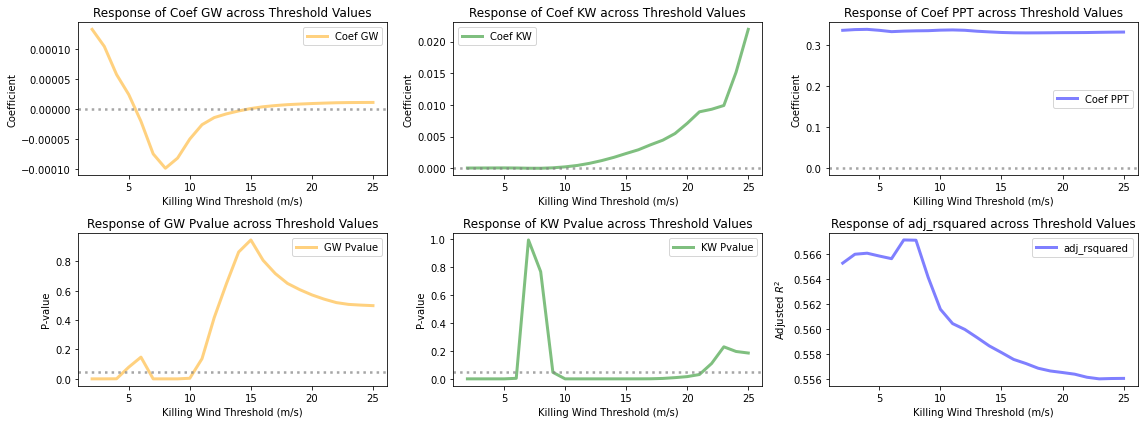

In [13]:
dict_df
t_vals = dict_df['threshold'].values
color = ['orange', 'green', 'blue']
cols = ['Coef GW', 'Coef KW', 'Coef PPT', 'GW Pvalue','KW Pvalue','adj_rsquared']
fig, ax = plt.subplots(2,3, figsize=(16,6))
for ind, col in enumerate(cols):
    plt.subplot(2,3, ind+1)
    plt.plot(t_vals, dict_df[col].values, color=color[ind%3], linewidth=3, label=col, alpha = 0.5)
    if ind <=2:
        plt.axhline(y = 0, color = 'grey', linewidth = 2.5, alpha = 0.7, linestyle = 'dotted')
        plt.ylabel("Coefficient")
    elif (ind==3) or (ind ==4):
        plt.axhline(y = 0.05, color = 'grey', linewidth = 2.5, alpha = 0.7, linestyle = 'dotted')
        plt.ylabel("P-value")
    else:
        plt.ylabel("Adjusted $R^2$")
    plt.title(f"Response of {col} across Threshold Values")
    plt.xlabel("Killing Wind Threshold (m/s)")

    plt.legend(loc = 'best');
plt.tight_layout()
plt.show()

In [9]:
df_mean = pd.read_csv("df_mean_Jan19.csv")
df_mean.head()

,Unnamed: 0,Year,State,County,lnyield,PPT,PPT2,GDD,KDD,MeanWindspeed,...,GW_18,GW_19,GW_20,GW_21,GW_22,GW_23,GW_24,GW_25,ST_CO,PPT_SQUARE
0,0,2007,ILLINOIS,ADAMS,5.087596,2.366576,28.417167,63549.935278,722.955833,4.126381,...,9895.773333,9895.773333,9895.773333,9895.773333,9895.773333,9895.773333,9895.773333,9895.773333,ILLINOIS_ADAMS,5.600681
1,1,2007,ILLINOIS,BOONE,5.204007,4.168070,140.545342,51046.743333,108.998889,4.371061,...,9877.590000,9877.916667,9877.916667,9877.916667,9877.916667,9877.916667,9877.916667,9877.916667,ILLINOIS_BOONE,17.372808
2,2,2007,ILLINOIS,BROWN,5.023881,2.108934,24.987999,62911.318056,667.070278,3.856494,...,9798.196667,9798.196667,9798.196667,9798.196667,9798.196667,9798.196667,9798.196667,9798.196667,ILLINOIS_BROWN,4.447603
3,3,2007,ILLINOIS,BUREAU,5.273000,4.162018,132.195968,57018.822222,264.909722,4.270713,...,9884.120000,9884.120000,9884.120000,9884.120000,9884.120000,9884.120000,9884.120000,9884.120000,ILLINOIS_BUREAU,17.322398
4,4,2007,ILLINOIS,CARROLL,5.231109,3.469018,68.213876,54177.402500,174.336389,4.351389,...,9853.523333,9854.076667,9854.333333,9854.333333,9854.333333,9854.333333,9854.333333,9854.333333,ILLINOIS_CARROLL,12.034088


In [10]:
pick_threshold = 20
df_9 = df_mean[["lnyield","Year","County","GDD","KDD",f"GW_{pick_threshold}",f"KW_{pick_threshold}","PPT","PPT_SQUARE"]].copy()
df_9[f"KW_{pick_threshold}_2"] = df_9[f"KW_{pick_threshold}"]**2
df_9[f"KW_{pick_threshold}_3"] = df_9[f"KW_{pick_threshold}"]**3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnyield   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     14.76
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:31:51   Log-Likelihood:                 1521.3
No. Observations:                4189   AIC:                            -2277.
Df Residuals:                    3806   BIC:                             151.7
Df Model:                         382                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.0749      0.091     44.999      0.000       3.897       4.252
C(Year)[T.2008]                  0.0363      0.013      2.866      0.004       0.011       0.061
C(Year)[T.2009]                  0.1665      0.014     11.873      0.000       0.139       0.194
C(Year)[T.2010]                  0.0389      0.011      3.476      0.001       0.017       0.061
C(Year)[T.2011]                  0.1356      0.014      9.735      0.000       0.108       0.163
C(Year)[T.2012]                 -0.0679      0.014     -4.825      0.000      -0.096      -0.040
C(Year)[T.2013]                  0.0800      0.012      6.517      0.000       0.056       0.104
C(Year)[T.2014]                  0.0695      0.011      6.157      0.000       0.047       0.092
C(County)[T.ADAMS]              -0.0587      0.067     -0.869      0.385      -0.191       0.074
C(County)[T.ALLAMAKEE]           0.0640      0.089      0.723      0.470      -0.110       0.238
C(County)[T.ALLEN]              -0.1023      0.077     -1.335      0.182      -0.253       0.048
C(County)[T.ANDERSON]           -0.4323      0.092     -4.706      0.000      -0.612      -0.252
C(County)[T.ANOKA]              -0.2609      0.089     -2.947      0.003      -0.435      -0.087
C(County)[T.ANTELOPE]            0.1472      0.088      1.665      0.096      -0.026       0.321
C(County)[T.APPANOOSE]          -0.2782      0.088     -3.144      0.002      -0.452      -0.105
C(County)[T.ATCHISON]           -0.0861      0.089     -0.972      0.331      -0.260       0.088
C(County)[T.ATHENS]             -0.1797      0.089     -2.030      0.042      -0.353      -0.006
C(County)[T.AUDRAIN]            -0.2696      0.088     -3.048      0.002      -0.443      -0.096
C(County)[T.AUDUBON]             0.0873      0.088      0.989      0.323      -0.086       0.260
C(County)[T.AUGLAIZE]           -0.1348      0.088     -1.524      0.128      -0.308       0.039
C(County)[T.AURORA]             -0.2647      0.092     -2.890      0.004      -0.444      -0.085
C(County)[T.BARNES]             -0.1339      0.089     -1.497      0.134      -0.309       0.041
C(County)[T.BARRON]             -0.1651      0.089     -1.855      0.064      -0.340       0.009
C(County)[T.BEADLE]             -0.0999      0.089     -1.128      0.259      -0.273       0.074
C(County)[T.BENTON]             -0.0594      0.072     -0.822      0.411      -0.201       0.082
C(County)[T.BIG STONE]          -0.0254      0.089     -0.286      0.775      -0.199       0.148
C(County)[T.BLACK HAWK]          0.0641      0.088      0.726      0.468      -0.109       0.237
C(County)[T.BLACKFORD]          -0.1092      0.088     -1.234      0.217      -0.283       0.064
C(County)[T.BLUE EARTH]          0.1082      0.088      1.223      0.221    

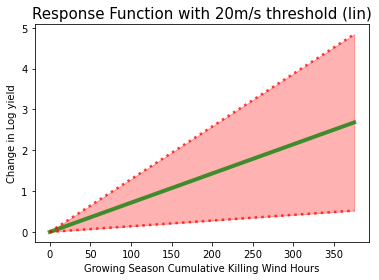

In [11]:
x = np.linspace(0, 375, 1000)
model_val = ols(f'lnyield ~ C(Year) + C(County) + GDD + KDD + KW_{pick_threshold} + PPT + PPT_SQUARE', data=df_9).fit()
y_med = model_val.params[f"KW_{pick_threshold}"]*x
y_lower = (model_val.params[f"KW_{pick_threshold}"] - 1.96*model_val.bse[f"KW_{pick_threshold}"])*x
y_upper =(model_val.params[f"KW_{pick_threshold}"] + 1.96* model_val.bse[f"KW_{pick_threshold}"])*x
plt.plot(x, y_med, color="green", alpha=0.75, linewidth=4)
plt.plot(x, y_lower, linestyle='dotted', linewidth=2.5, alpha=0.75, color = 'red')
plt.plot(x, y_upper, linestyle='dotted', linewidth=2.5, alpha=0.75, color = 'red')
plt.fill_between(x, y_lower, y_upper, color='red',alpha=0.3)
plt.ylabel("Change in Log yield")
plt.xlabel("Growing Season Cumulative Killing Wind Hours")
plt.title(f"Response Function with {pick_threshold}m/s threshold (lin)", fontsize=15);
model_val.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnyield   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     14.73
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:32:05   Log-Likelihood:                 1522.4
No. Observations:                4189   AIC:                            -2277.
Df Residuals:                    3805   BIC:                             157.8
Df Model:                         383                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.0747      0.091     45.003      0.000       3.897       4.252
C(Year)[T.2008]                  0.0357      0.013      2.820      0.005       0.011       0.061
C(Year)[T.2009]                  0.1668      0.014     11.896      0.000       0.139       0.194
C(Year)[T.2010]                  0.0386      0.011      3.447      0.001       0.017       0.061
C(Year)[T.2011]                  0.1353      0.014      9.711      0.000       0.108       0.163
C(Year)[T.2012]                 -0.0687      0.014     -4.880      0.000      -0.096      -0.041
C(Year)[T.2013]                  0.0797      0.012      6.489      0.000       0.056       0.104
C(Year)[T.2014]                  0.0685      0.011      6.057      0.000       0.046       0.091
C(County)[T.ADAMS]              -0.0602      0.067     -0.893      0.372      -0.193       0.072
C(County)[T.ALLAMAKEE]           0.0647      0.088      0.731      0.465      -0.109       0.238
C(County)[T.ALLEN]              -0.1025      0.077     -1.338      0.181      -0.253       0.048
C(County)[T.ANDERSON]           -0.4334      0.092     -4.719      0.000      -0.614      -0.253
C(County)[T.ANOKA]              -0.2607      0.089     -2.944      0.003      -0.434      -0.087
C(County)[T.ANTELOPE]            0.1443      0.088      1.632      0.103      -0.029       0.318
C(County)[T.APPANOOSE]          -0.2785      0.088     -3.148      0.002      -0.452      -0.105
C(County)[T.ATCHISON]           -0.0874      0.089     -0.986      0.324      -0.261       0.086
C(County)[T.ATHENS]             -0.1795      0.089     -2.028      0.043      -0.353      -0.006
C(County)[T.AUDRAIN]            -0.2694      0.088     -3.047      0.002      -0.443      -0.096
C(County)[T.AUDUBON]             0.0867      0.088      0.982      0.326      -0.086       0.260
C(County)[T.AUGLAIZE]           -0.1347      0.088     -1.523      0.128      -0.308       0.039
C(County)[T.AURORA]             -0.2698      0.092     -2.945      0.003      -0.449      -0.090
C(County)[T.BARNES]             -0.1361      0.089     -1.522      0.128      -0.311       0.039
C(County)[T.BARRON]             -0.1642      0.089     -1.845      0.065      -0.339       0.010
C(County)[T.BEADLE]             -0.0998      0.088     -1.128      0.259      -0.273       0.074
C(County)[T.BENTON]             -0.0600      0.072     -0.831      0.406      -0.202       0.082
C(County)[T.BIG STONE]          -0.0293      0.089     -0.330      0.741      -0.203       0.145
C(County)[T.BLACK HAWK]          0.0633      0.088      0.717      0.474      -0.110       0.236
C(County)[T.BLACKFORD]          -0.1101      0.088     -1.246      0.213      -0.283       0.063
C(County)[T.BLUE EARTH]          0.1055      0.088      1.192      0.233    

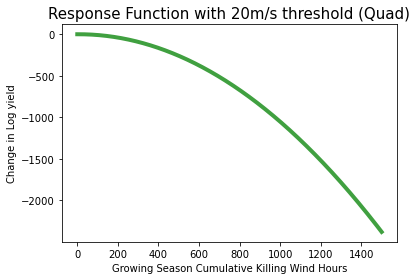

In [12]:
# print(model_val.params["KW_9"], 9.27*10**(-7),0)
# df_mean[["KW_9"]].describe()
model_val = ols(f'lnyield ~ C(Year) + C(County) + GDD + KDD + KW_{pick_threshold} + KW_{pick_threshold}_2  + PPT + PPT_SQUARE', data=df_9).fit()
x = np.linspace(0, 1500, 1000)
y_med = model_val.params[f"KW_{pick_threshold}"]*x + model_val.params[f"KW_{pick_threshold}_2"]*x**2 #+model_val.params["KW_9_3"]*x**3
# y_lower = (model_val.params["KW_9"] - 1.96* 9.6*(10**(-5)))*x #+(model_val.params["KW_9_2"] - 
#                     #1.96* 9.82*(10**(-7)))*x**2 + (model_val.params["KW_9_3"] - 1.96* 9.9*(10**(-11)))*x**3
# y_upper =(model_val.params["KW_9"] + 1.96* 9.6*(10**(-5)))*x #+ (model_val.params["KW_9_2"] + 
#                    # 1.96* 9.82*(10**(-7)))*x**2+(model_val.params["KW_9_3"] + 1.96* 9.9*(10**(-11)))*x**3
plt.plot(x, y_med, color="green", alpha=0.75, linewidth=4)

plt.ylabel("Change in Log yield")
plt.xlabel("Growing Season Cumulative Killing Wind Hours")
plt.title(f"Response Function with {pick_threshold}m/s threshold (Quad)", fontsize=15);
model_val.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnyield   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     14.70
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:32:23   Log-Likelihood:                 1523.5
No. Observations:                4189   AIC:                            -2277.
Df Residuals:                    3804   BIC:                             164.0
Df Model:                         384                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.0755      0.091     45.017      0.000       3.898       4.253
C(Year)[T.2008]                  0.0353      0.013      2.782      0.005       0.010       0.060
C(Year)[T.2009]                  0.1670      0.014     11.910      0.000       0.139       0.194
C(Year)[T.2010]                  0.0384      0.011      3.428      0.001       0.016       0.060
C(Year)[T.2011]                  0.1350      0.014      9.694      0.000       0.108       0.162
C(Year)[T.2012]                 -0.0698      0.014     -4.951      0.000      -0.097      -0.042
C(Year)[T.2013]                  0.0793      0.012      6.454      0.000       0.055       0.103
C(Year)[T.2014]                  0.0674      0.011      5.947      0.000       0.045       0.090
C(County)[T.ADAMS]              -0.0611      0.067     -0.906      0.365      -0.193       0.071
C(County)[T.ALLAMAKEE]           0.0655      0.088      0.740      0.459      -0.108       0.239
C(County)[T.ALLEN]              -0.1028      0.077     -1.342      0.180      -0.253       0.047
C(County)[T.ANDERSON]           -0.4350      0.092     -4.736      0.000      -0.615      -0.255
C(County)[T.ANOKA]              -0.2606      0.089     -2.944      0.003      -0.434      -0.087
C(County)[T.ANTELOPE]            0.1424      0.088      1.611      0.107      -0.031       0.316
C(County)[T.APPANOOSE]          -0.2788      0.088     -3.151      0.002      -0.452      -0.105
C(County)[T.ATCHISON]           -0.0872      0.089     -0.984      0.325      -0.261       0.087
C(County)[T.ATHENS]             -0.1788      0.089     -2.021      0.043      -0.352      -0.005
C(County)[T.AUDRAIN]            -0.2690      0.088     -3.042      0.002      -0.442      -0.096
C(County)[T.AUDUBON]             0.0859      0.088      0.973      0.331      -0.087       0.259
C(County)[T.AUGLAIZE]           -0.1344      0.088     -1.520      0.128      -0.308       0.039
C(County)[T.AURORA]             -0.2742      0.092     -2.991      0.003      -0.454      -0.094
C(County)[T.BARNES]             -0.1390      0.089     -1.554      0.120      -0.314       0.036
C(County)[T.BARRON]             -0.1634      0.089     -1.836      0.066      -0.338       0.011
C(County)[T.BEADLE]             -0.1000      0.088     -1.131      0.258      -0.274       0.073
C(County)[T.BENTON]             -0.0610      0.072     -0.845      0.398      -0.202       0.081
C(County)[T.BIG STONE]          -0.0319      0.089     -0.360      0.719      -0.206       0.142
C(County)[T.BLACK HAWK]          0.0635      0.088      0.719      0.472      -0.110       0.237
C(County)[T.BLACKFORD]          -0.1110      0.088     -1.256      0.209      -0.284       0.062
C(County)[T.BLUE EARTH]          0.1055      0.088      1.192      0.233    

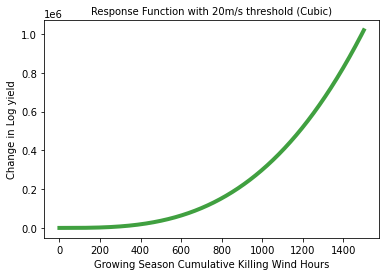

In [14]:
model_val = ols(f'lnyield ~ C(Year) + C(County) + GDD + KDD + KW_{pick_threshold} + KW_{pick_threshold}_2 +KW_{pick_threshold}_3 + PPT + PPT_SQUARE', data=df_9).fit()
x = np.linspace(0, 1500, 1000)
y_med = model_val.params[f"KW_{pick_threshold}"]*x + model_val.params[f"KW_{pick_threshold}_2"]*x**2 + model_val.params[f"KW_{pick_threshold}_3"]*x**3 
plt.plot(x, y_med, color="green", alpha=0.75, linewidth=4)
plt.ylabel("Change in Log yield")
plt.xlabel("Growing Season Cumulative Killing Wind Hours")
plt.title(f"Response Function with {pick_threshold}m/s threshold (Cubic)", fontsize=10);
model_val.summary()

In [72]:
df_mean[["KW_9"]].describe()

,KW_9
count,4189.000000
mean,284.564815
std,203.996882
min,0.000000
25%,142.136667
50%,224.560000
75%,375.830000
max,1670.060000


In [43]:
 1.96 * 3.22*(10**(-5))

6.311200000000002e-05

In [ ]:
df_mean.to_csv("")